In [2]:
pip install dask


In [8]:
# Import Dask DataFrame
import dask.dataframe as dd

# Load the dataset into a Dask DataFrame, specifying dtypes
df = dd.read_csv("/content/Tweets.csv", dtype={'airline_sentiment_gold': 'object',
                                               'negativereason_gold': 'object',
                                               'tweet_coord': 'object'})

# Display the first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,<NA>,NaN,Virgin America,<NA>,cairdin,<NA>,0,@VirginAmerica What @dhepburn said.,<NA>,2015-02-24 11:35:52 -0800,<NA>,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,<NA>,0.0000,Virgin America,<NA>,jnardino,<NA>,0,@VirginAmerica plus you've added commercials t...,<NA>,2015-02-24 11:15:59 -0800,<NA>,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,<NA>,NaN,Virgin America,<NA>,yvonnalynn,<NA>,0,@VirginAmerica I didn't today... Must mean I n...,<NA>,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,<NA>,jnardino,<NA>,0,@VirginAmerica it's really aggressive to blast...,<NA>,2015-02-24 11:15:36 -0800,<NA>,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,<NA>,jnardino,<NA>,0,@VirginAmerica and it's a really big bad thing...,<NA>,2015-02-24 11:14:45 -0800,<NA>,Pacific Time (US & Canada)


In [9]:
# Drop unnecessary columns
df = df.drop(columns=["tweet_id", "airline_sentiment_confidence", "negativereason_confidence"])

# Filter out rows with missing values
df = df.dropna(subset=["airline_sentiment", "text"])

In [10]:
# Count the number of tweets for each sentiment
sentiment_counts = df["airline_sentiment"].value_counts().compute()
print(sentiment_counts)

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64[pyarrow]


In [11]:
# Filter for negative sentiment and count reasons
negative_reasons = df[df["airline_sentiment"] == "negative"]["negativereason"] \
                   .value_counts().compute()
print(negative_reasons)

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64[pyarrow]


In [12]:
# Group by airline and sentiment, then count
airline_sentiment = df.groupby(["airline", "airline_sentiment"]).size().compute()
print(airline_sentiment)

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
dtype: int64


# sentiment distribution

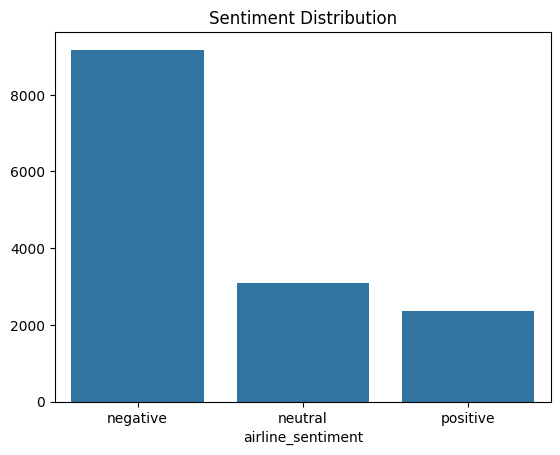

In [17]:
# Plot sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.show()

##Sentiment Distribution by Airline: Stacked bar chart.





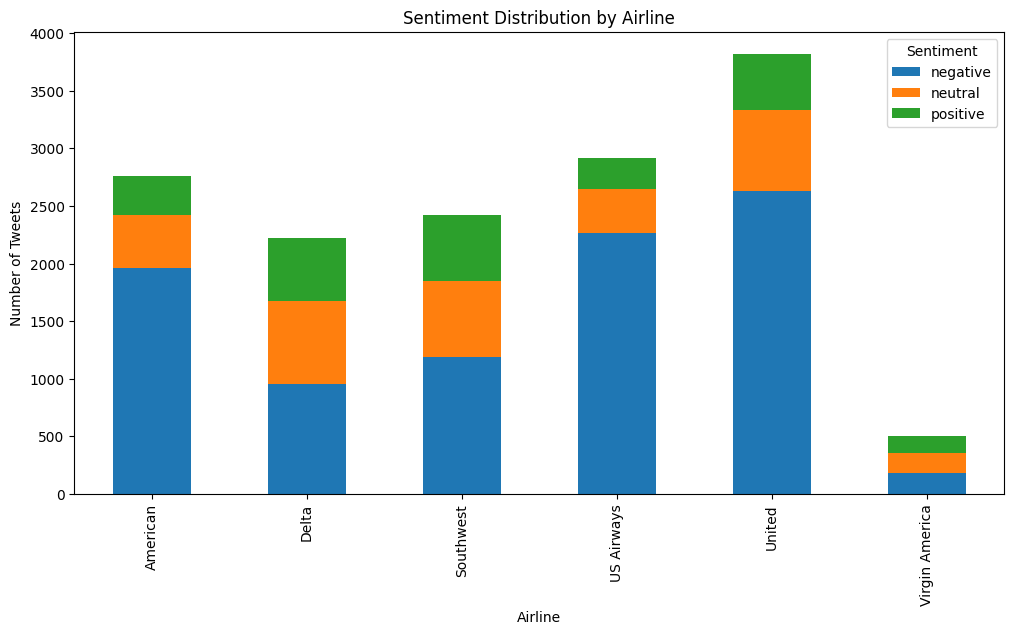

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by airline and sentiment, then compute the counts
airline_sentiment = df.groupby(["airline", "airline_sentiment"]).size().compute().unstack()

# Plot the results
airline_sentiment.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Sentiment Distribution by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.show()


##Word Cloud for Negative Tweets: Visualizes common words in negative tweets.


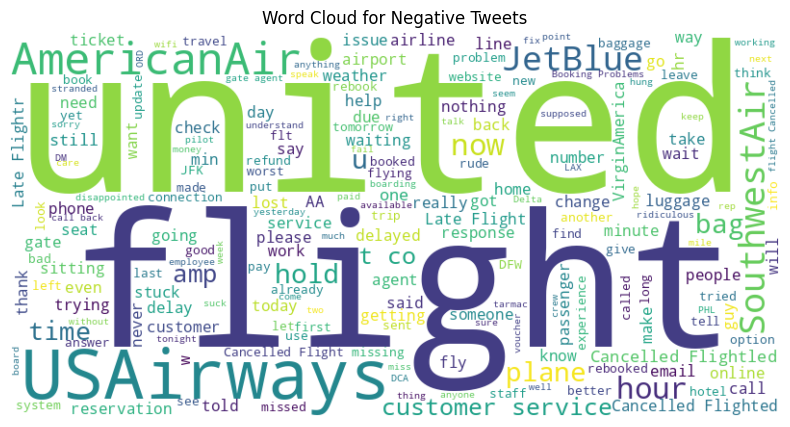

In [20]:
from wordcloud import WordCloud

# Filter negative tweets and extract text
negative_tweets = df[df["airline_sentiment"] == "negative"]["text"].compute()

# Combine all negative tweets into a single string
negative_text = " ".join(negative_tweets)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Tweets")
plt.show()

##Distribution of Negative Reasons: Bar chart of negative reasons

<ipython-input-21-d132fa52c954>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=negative_reasons.index, y=negative_reasons.values, palette="viridis")


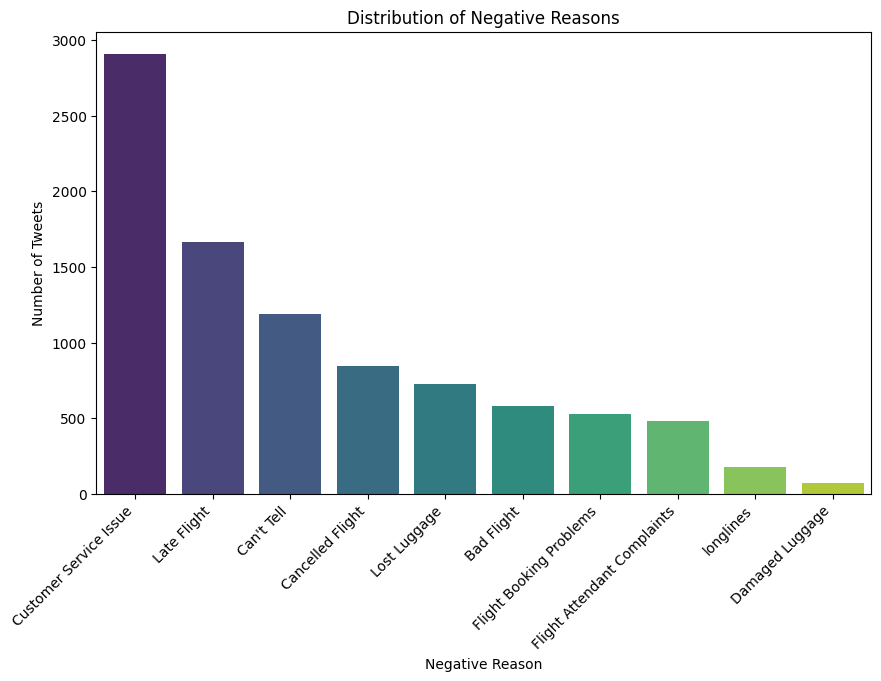

In [21]:
# Filter for negative sentiment and compute the counts of reasons
negative_reasons = df[df["airline_sentiment"] == "negative"]["negativereason"] \
                   .value_counts().compute()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=negative_reasons.index, y=negative_reasons.values, palette="viridis")
plt.title("Distribution of Negative Reasons")
plt.xlabel("Negative Reason")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45, ha="right")
plt.show()

##Time Series of Tweets: Line chart of tweets over time.

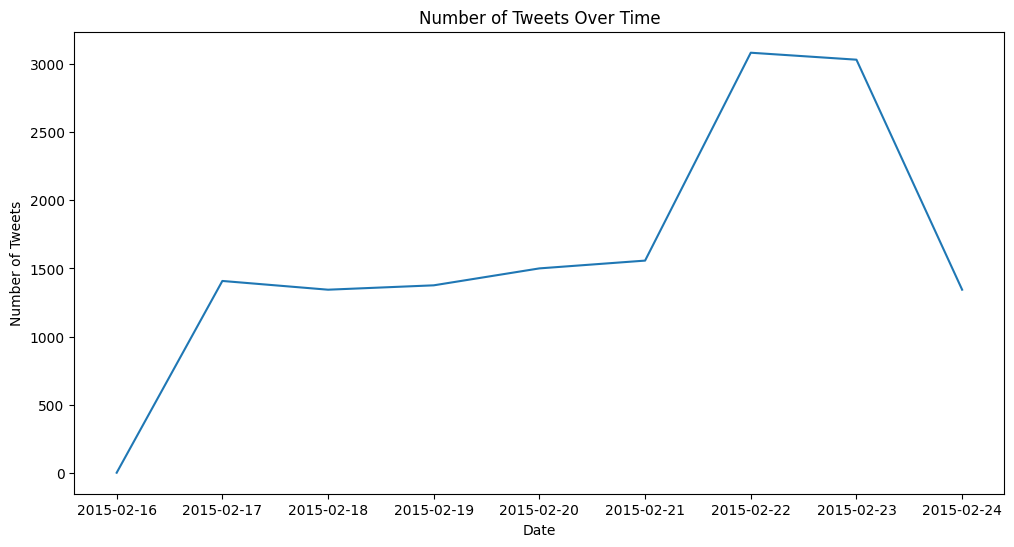

In [22]:
# Convert the 'tweet_created' column to datetime
df["tweet_created"] = dd.to_datetime(df["tweet_created"])

# Group by date and compute the number of tweets per day
tweets_over_time = df.groupby(df["tweet_created"].dt.date).size().compute()

# Plot the results
plt.figure(figsize=(12, 6))
tweets_over_time.plot(kind="line")
plt.title("Number of Tweets Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.show()

# Sentiment Proportion by Airline: Stacked bar chart (normalized).

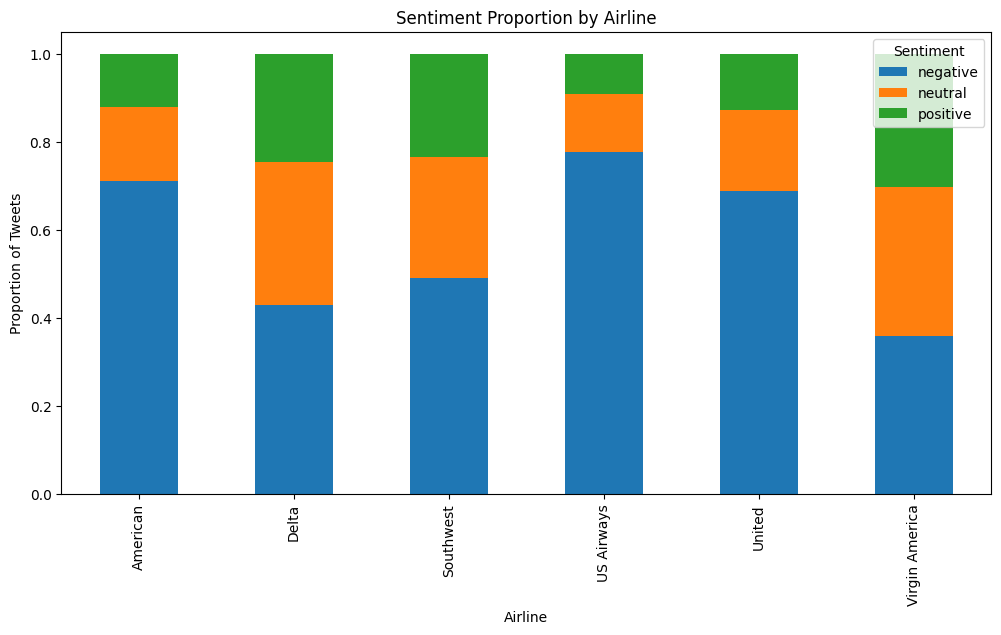

In [23]:
# Calculate the proportion of sentiments for each airline
airline_sentiment_proportion = airline_sentiment.div(airline_sentiment.sum(axis=1), axis=0)

# Plot the results
airline_sentiment_proportion.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Sentiment Proportion by Airline")
plt.xlabel("Airline")
plt.ylabel("Proportion of Tweets")
plt.legend(title="Sentiment")
plt.show()

In [18]:
# Save the processed DataFrame to CSV files
df.to_csv("path/to/output/*.csv")

['/content/path/to/output/0.csv']